# Missing Value Prediction

As we will see in this notebook, the dataset is missing values in many columns and rows, and in an attempt to limit the loss of data, we will try to impute values by predicitons. We will try to identify the columns that could benefit from this, and eliminate those that would not.

In [1]:
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import builtins

from functools import reduce

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, sum, unix_timestamp, hour, dayofweek, when, corr
from pyspark.sql.types import NumericType, BooleanType, StringType, TimestampType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.master("local[*]").appName("accidents").config("spark.driver.memory", "10g").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/19 17:06:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
data = spark.read.csv(f"US_Accidents_March23.csv", header=True, inferSchema=True)
data.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [4]:
def print_null_counts(df, show_count=20):
    null_df = df.select(
        [
            sum(col(c).isNull().cast("int")).alias(c)
            for c in df.columns
        ]
    )

    rows = null_df.collect()
    counts = {
        c: rows[0][i] for i, c in enumerate(df.columns)
    }

    counts_df = spark.createDataFrame([(k, v) for k, v in counts.items()], ["Column name", "Null Count"])
    counts_df.orderBy("Null Count", ascending=False).show(show_count)

In [5]:
print_null_counts(data, 23)

+--------------------+----------+
|         Column name|Null Count|
+--------------------+----------+
|             End_Lat|   3402762|
|             End_Lng|   3402762|
|   Precipitation(in)|   2203586|
|       Wind_Chill(F)|   1999019|
|     Wind_Speed(mph)|    571233|
|      Visibility(mi)|    177098|
|      Wind_Direction|    175206|
|         Humidity(%)|    174144|
|   Weather_Condition|    173459|
|      Temperature(F)|    163853|
|        Pressure(in)|    140679|
|   Weather_Timestamp|    120228|
|      Sunrise_Sunset|     23246|
|      Civil_Twilight|     23246|
|   Nautical_Twilight|     23246|
|Astronomical_Twil...|     23246|
|        Airport_Code|     22635|
|              Street|     10869|
|            Timezone|      7808|
|             Zipcode|      1915|
|                City|       253|
|         Description|         5|
|                Bump|         0|
+--------------------+----------+
only showing top 23 rows



In [6]:
missing_values = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).collect()[0].asDict()
missing_values_df = pd.DataFrame(missing_values.items(), columns=["Column", "Missing Values"]).sort_values(by="Missing Values", ascending=False)

chart = alt.Chart(missing_values_df, title="Missing values by column").mark_bar().encode(
    x=alt.X("Column", title="Colonnes", sort=None),
    y=alt.Y("Missing Values", title="Number of missing values"),
).properties(width=800, height=400)

chart

alt.Chart(...)

The above bar chart gives us an idea of which columns coulb be worth predicting. We are looking for a column with enough missing values to warrant training a model, and that has good enough correlation with other columns to get good results. Looking at the columns with the most missing values, we see the following ones stand out:
 - End_Lng - 3 402 762 missing values
 - End_Lat - 3 402 762 missing values
 - Precipitation(in) - 2 203 586 missing values
 - Wind_Chill(F) - 1 999 019 missing values
 - Wind_Speed(mph) - 571 233 missing values

Let's have a closer look at each of these.

## Feature analysis

Let's first have a look at the longitude and latitude columns

Records with complete coordinate data: 4,325,632


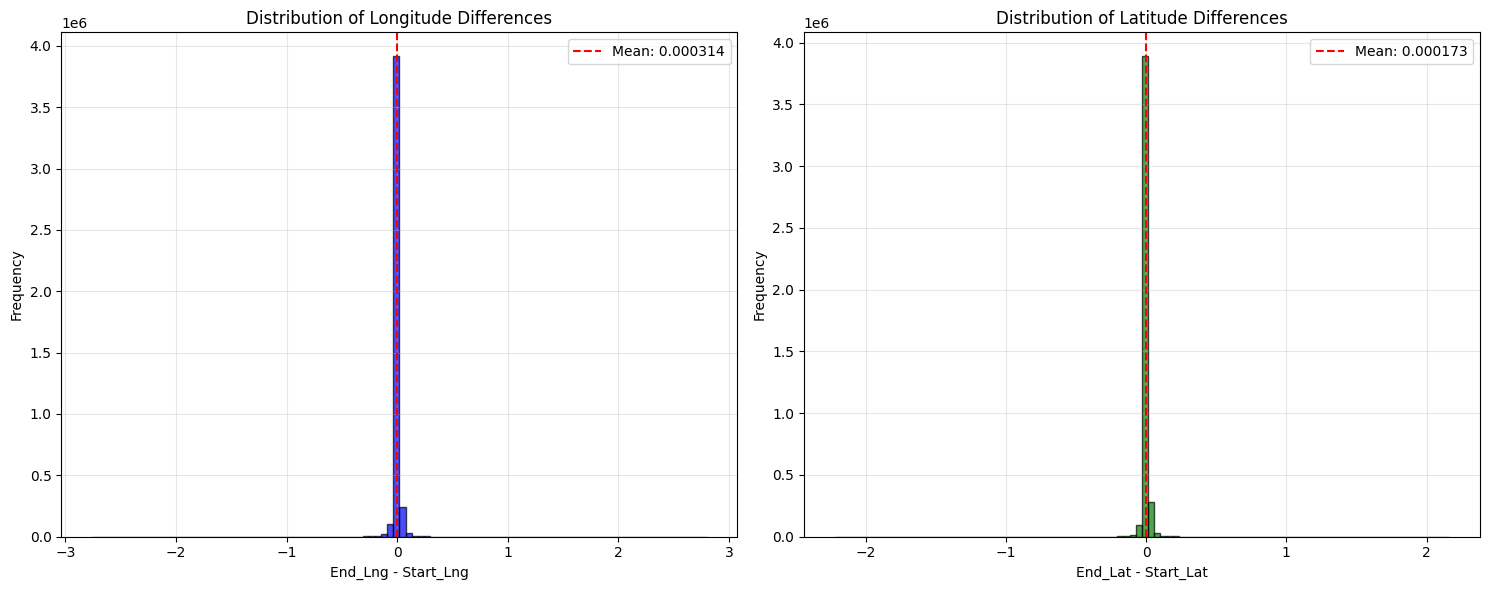

In [7]:
coord_data = data.filter(
    col('Start_Lng').isNotNull() & 
    col('End_Lng').isNotNull() & 
    col('Start_Lat').isNotNull() & 
    col('End_Lat').isNotNull()
)

print(f"Records with complete coordinate data: {coord_data.count():,}")

coord_diff = coord_data.withColumn(
    'lng_diff', col('End_Lng') - col('Start_Lng')
).withColumn(
    'lat_diff', col('End_Lat') - col('Start_Lat')
)

lng_diffs = [row['lng_diff'] for row in coord_diff.select('lng_diff').collect()]
lat_diffs = [row['lat_diff'] for row in coord_diff.select('lat_diff').collect()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.hist(lng_diffs, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('End_Lng - Start_Lng')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Longitude Differences')
ax1.grid(True, alpha=0.3)

lng_mean = np.mean(lng_diffs)
lng_std = np.std(lng_diffs)
ax1.axvline(lng_mean, color='red', linestyle='--', label=f'Mean: {lng_mean:.6f}')
ax1.legend()

ax2.hist(lat_diffs, bins=100, alpha=0.7, color='green', edgecolor='black')
ax2.set_xlabel('End_Lat - Start_Lat')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Latitude Differences')
ax2.grid(True, alpha=0.3)

lat_mean = np.mean(lat_diffs)
lat_std = np.std(lat_diffs)
ax2.axvline(lat_mean, color='red', linestyle='--', label=f'Mean: {lat_mean:.6f}')
ax2.legend()

plt.tight_layout()
plt.show()

As we can see in the above graphs, the difference between start and end longitutde/latitude is marginal is most cases, if not zero. We can except the End_Lng and End_Lat feature to not bring any additional information to the task, so we will drop them.

In [95]:
cleaned = data.drop('End_Lng', 'End_Lat')

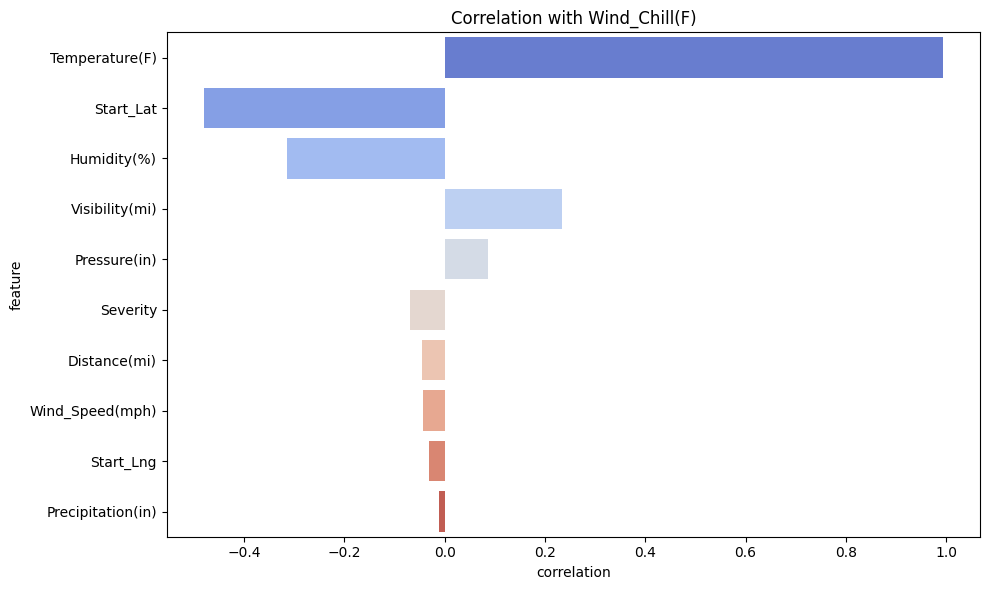

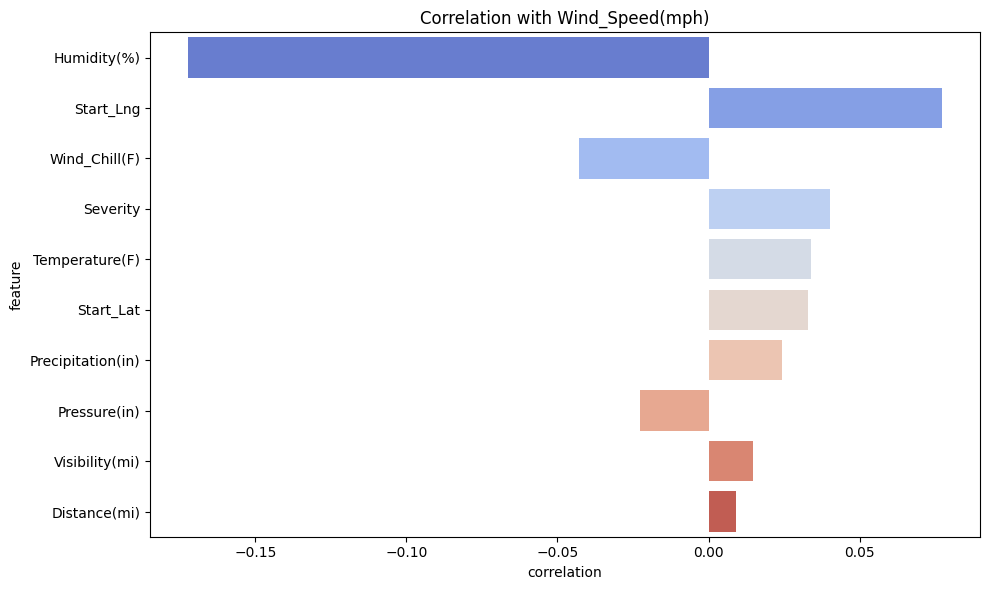

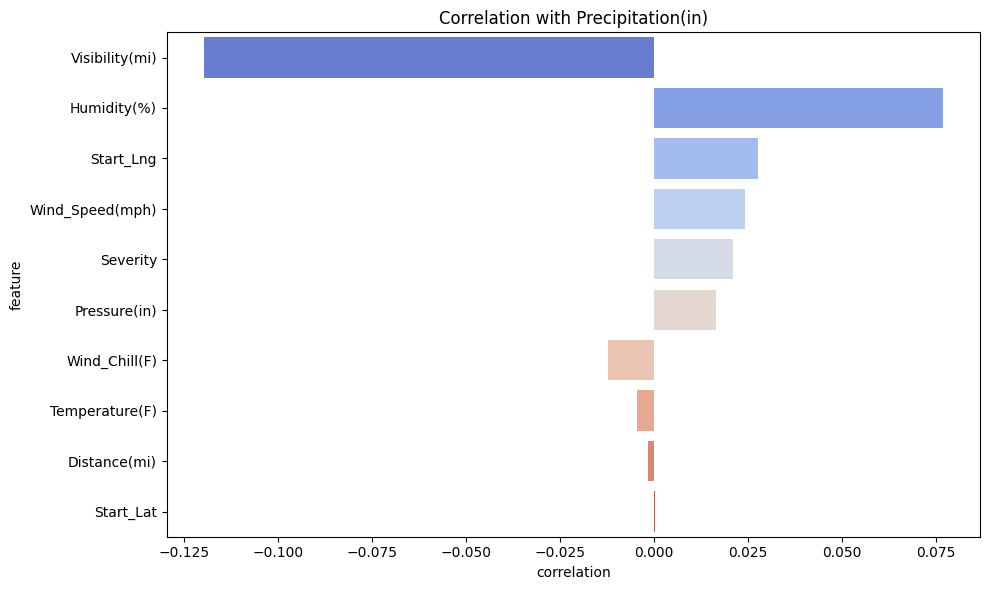

In [9]:
numeric_cols = [
    f.name for f in cleaned.schema.fields
    if isinstance(f.dataType, NumericType)
]

wind_chill_cols = [c for c in numeric_cols if c != "Wind_Chill(F)"]
wind_speed_cols = [c for c in numeric_cols if c != "Wind_Speed(mph)"]
precipitation_cols = [c for c in numeric_cols if c != "Precipitation(in)"]

wind_chill_correlations = [
    (col_name, cleaned.select(corr(col_name, "Wind_Chill(F)")).first()[0])
    for col_name in wind_chill_cols
]
wind_speed_correlations = [
    (col_name, cleaned.select(corr(col_name, "Wind_Speed(mph)")).first()[0])
    for col_name in wind_speed_cols
]
precipitation_correlations = [
    (col_name, cleaned.select(corr(col_name, "Precipitation(in)")).first()[0])
    for col_name in precipitation_cols
]

wind_chill_corr_df = pd.DataFrame(wind_chill_correlations, columns=["feature", "correlation"])
wind_chill_corr_df = wind_chill_corr_df.dropna().sort_values("correlation", key=abs, ascending=False)

wind_speed_corr_df = pd.DataFrame(wind_speed_correlations, columns=["feature", "correlation"])
wind_speed_corr_df = wind_speed_corr_df.dropna().sort_values("correlation", key=abs, ascending=False)

precipitation_corr_df = pd.DataFrame(precipitation_correlations, columns=["feature", "correlation"])
precipitation_corr_df = precipitation_corr_df.dropna().sort_values("correlation", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=wind_chill_corr_df, x="correlation", y="feature", palette="coolwarm", hue="feature")
plt.title(f"Correlation with Wind_Chill(F)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=wind_speed_corr_df, x="correlation", y="feature", palette="coolwarm", hue="feature")
plt.title(f"Correlation with Wind_Speed(mph)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.barplot(data=precipitation_corr_df, x="correlation", y="feature", palette="coolwarm", hue="feature")
plt.title(f"Correlation with Precipitation(in)")
plt.tight_layout()
plt.show()

As we can observe, the wind chill feature is redundant with the temperature feature. As it does not bring any additional infromation, we will drop it. On the other hand, wind speed and precipitation are weakly correlated to the other numerical features. Since precipitation contains 4 times more missing values than wind speed, we will focus on it.

In [96]:
cleaned = cleaned.drop("Wind_Chill(F)")

### Data preprocessing

Before we proceed, we need to handle missing values. We will do so by removing all rows containing any missing values.

In [97]:
to_filter = [c for c in cleaned.columns if c != 'Precipitation(in)']

cleaned = cleaned.na.drop(subset=to_filter)

In [12]:
print_null_counts(cleaned, 2)

+-----------------+----------+
|      Column name|Null Count|
+-----------------+----------+
|Precipitation(in)|   1689924|
|       Start_Time|         0|
+-----------------+----------+
only showing top 2 rows



In [13]:
cleaned.count()

7051556

Now, let's have a look at the contents of the dataset

In [14]:
cleaned.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullabl

In [15]:
numeric_cols = [f.name for f in data.schema.fields if isinstance(f.dataType, (NumericType, BooleanType))]
string_cols = [f.name for f in data.schema.fields if isinstance(f.dataType, StringType)]
timestamp_cols = [f.name for f in data.schema.fields if isinstance(f.dataType, TimestampType)]

print(f'Numeric columns count: {len(numeric_cols)}')
print(f'String columns count: {len(string_cols)}')
print(f'Timestamp columns count: {len(timestamp_cols)}')

Numeric columns count: 26
String columns count: 17
Timestamp columns count: 3


#### String features

In [16]:
string_counts = {}

for c in string_cols:
    count = data.select(col(c)).distinct().count()
    string_counts[c] = count
    print(f"Column {c}: {count}")

Column ID: 7728394


Column Source: 3


Column Description: 3761579


Column Street: 336307


Column City: 13679


Column County: 1871


Column State: 49


Column Zipcode: 825095


Column Country: 1


Column Timezone: 5


Column Airport_Code: 2046


Column Wind_Direction: 25


Column Weather_Condition: 145


Column Sunrise_Sunset: 3


Column Civil_Twilight: 3


Column Nautical_Twilight: 3


Column Astronomical_Twilight: 3


In the above cell, we print the count of unique values of each string feature. The goal is to assess which ones can be binarized while keeping reasonable dimensionality.

Some columns can be eliminated for lack of significant information. Although a feature like description could hold some interesting information, in this case it is more likely to not bring much, considering that the task is to predict precipitation, and that handling text is an NLP task in itself.

City, County, Zipcode, Street, and Airport Code all contain to many unique values. This introduces two problems: the data might be too specific for the model to be able to generalize, and the computational cost increases greatly. For those reasons, these features are excluded.

We can notice that the Sunrise_Sunset, Civil_Twilight, Nautical_Twilight and Astronomical_Twilight features already contain boolean values, they simply have to be cast to the boolean type.

The country feature brings no information, as it contains the sole value "US"

Lastly, the source features seems to represent metadata, not interesting for the prediction.

We have the following string features to handle:
 - State - Can be useful when predicting precipitation, as whether conditions likely vary from on state to the next.
 - Timezone - These can give an additional indication of geographical location.
 - Wind_Direction - Possibly useful, might not offer too much additional information.
 - Weather_Condtion - Likely the most useful feature.

In [98]:
cleaned = cleaned.drop('Description', 'Street', 'Zipcode', 'Country', 'City', 'Airport_Code', 'County', 'Source')

In [99]:
categorical_cols = ['State', 'Timezone', 'Wind_Direction', 'Weather_Condition']

indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep")
    for col in categorical_cols
]

In [100]:
indexer_pipeline = Pipeline(stages=indexers)
model = indexer_pipeline.fit(cleaned)
cleaned_encoded = model.transform(cleaned)

In [101]:
boolean_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

for c in boolean_cols:
    cleaned_encoded = cleaned_encoded.withColumn(
        c,
        when(col(c) == "Day", True).when(col(c) == "Night", False).otherwise(None)
    )

In [102]:
cleaned_encoded = cleaned_encoded.drop(*categorical_cols)

#### Timestamp features

To handle timestamp features, we can do some feature engineering to extract information that a prediction model can better understand. For example, the day of the week, the time of day and the length of the accident.

In [103]:
cleaned_encoded = (
    cleaned_encoded.withColumn("Hour", hour("Start_Time"))
      .withColumn("Day_of_week", dayofweek("Start_Time"))
      .withColumn("Is_weekend", when(dayofweek("Start_Time").isin([1, 7]), 1).otherwise(0))
      .withColumn("Is_night", when(hour("Start_Time").between(0, 6), 1).otherwise(0))
)

cleaned_encoded = cleaned_encoded.withColumn(
    "duration",
    (unix_timestamp("End_Time") - unix_timestamp("Start_Time")) / 60
)

In [104]:
cleaned_encoded = cleaned_encoded.drop('Start_Time', 'End_Time', 'Weather_Timestamp')

In [24]:
cleaned_encoded.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Turning_Loop: boolean (nullable = true)
 |-- Sunrise_

In [25]:
target_col = "Precipitation(in)"

numeric_cols = [
    f.name for f in cleaned_encoded.schema.fields
    if isinstance(f.dataType, NumericType) and f.name != target_col
]

correlations = [
    (col_name, cleaned_encoded.select(corr(col_name, target_col)).first()[0])
    for col_name in numeric_cols
]

In [26]:
corr_df = pd.DataFrame(correlations, columns=["feature", "correlation"])
corr_df = corr_df.dropna().sort_values("correlation", key=abs, ascending=False)

/tmp/ipykernel_124117/53962812.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x="correlation", y="feature", palette="coolwarm")


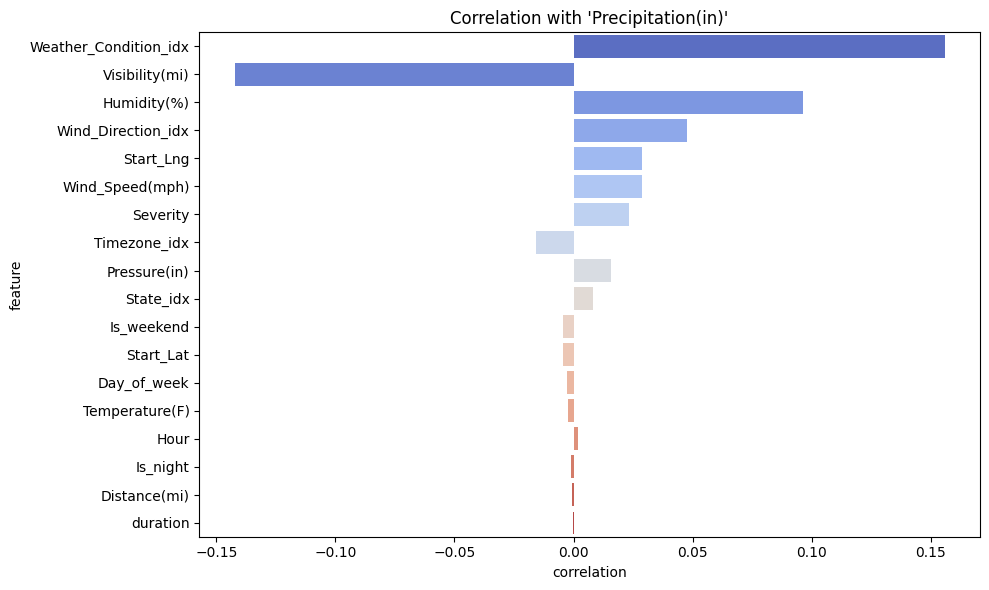

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(data=corr_df, x="correlation", y="feature", palette="coolwarm")
plt.title(f"Correlation with '{target_col}'")
plt.tight_layout()
plt.show()

As suspected, the feature most correlated to precipitation is weather condition, although they are not stronly correlated. This could be a result of how the indexing of the weather condition column was done, as the values were not sorted. Let's now convert the ordinal features to one hot vectors.

In [105]:
encoders = [
    OneHotEncoder(inputCol=col + '_idx', outputCol=col + "_ohe", handleInvalid="keep")
    for col in categorical_cols
]

In [106]:
ohe_pipeline = Pipeline(stages=encoders)
model = ohe_pipeline.fit(cleaned_encoded)
cleaned_encoded = model.transform(cleaned_encoded)

In [107]:
cleaned_encoded = cleaned_encoded.drop(*[c + '_idx' for c in categorical_cols])

In [108]:
cleaned_encoded.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: boolean (nullable = true)
 |-- Traffic_Signal: boolean (nullable = true)
 |-- Turning_Loop: boole

### Model training

We now need to split the dataset several ways:
 - One split containing all the rows with missing values; These should not be used for training or testing
 - A training split, 70%
 - A test split, 30%

In [109]:
missing_val_df = cleaned_encoded.filter(
    col("Precipitation(in)").isNull()
)

full_df = cleaned_encoded.filter(
    col("Precipitation(in)").isNotNull()
)

print_null_counts(missing_val_df, 2)
print_null_counts(full_df, 2)

print(f"Value counts for full df: {full_df.count()}")
print(f"Value counts for missgin value df: {missing_val_df.count()}")

+-----------------+----------+
|      Column name|Null Count|
+-----------------+----------+
|Precipitation(in)|   1689924|
|   Sunrise_Sunset|         0|
+-----------------+----------+
only showing top 2 rows



+-----------+----------+
|Column name|Null Count|
+-----------+----------+
|  Start_Lng|         0|
| Roundabout|         0|
+-----------+----------+
only showing top 2 rows



Value counts for full df: 5361632


Value counts for missgin value df: 1689924


##### Feature scaling

We will scale the numerical features as well as the target features before training.

In [110]:
target = 'Precipitation(in)'
to_scale = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
            'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'duration']
rest_cols = [f.name for f in cleaned_encoded.schema.fields if f.name not in to_scale and f.name != target and f.name != 'ID']

In [112]:
scale_assembler = VectorAssembler(inputCols=to_scale, outputCol="to_scale")
scaled = scale_assembler.transform(full_df)
missing_val_scaled = scale_assembler.transform(missing_val_df)

In [113]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol='to_scale',
    outputCol='scaled',
    withMean=True,
    withStd=True,
)

scaler_model = scaler.fit(scaled)
scaled = scaler_model.transform(scaled)

scaled_model = scaler.fit(missing_val_scaled)
missing_val_scaled = scaler_model.transform(missing_val_scaled)

In [114]:
# Assemble all features
rest_assembler = VectorAssembler(inputCols=[*rest_cols, 'scaled'], outputCol='features')
merged = rest_assembler.transform(scaled)
missing_val_merged = rest_assembler.transform(missing_val_scaled)

In [74]:
train_split, test_split = merged.randomSplit([0.8, 0.2], seed=42)

In [75]:
target = 'Precipitation(in)'
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")

In [76]:
lr = LinearRegression(featuresCol="features", labelCol=target)
lr_model = lr.fit(train_split)

lr_predictions = lr_model.transform(test_split)

evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction")

lr_rmse = evaluator.setMetricName("rmse").evaluate(lr_predictions)
lr_r2 = evaluator.setMetricName("r2").evaluate(lr_predictions)

print(f"[Linear Regression] RMSE: {lr_rmse}")
print(f"[Linear Regression] R²: {lr_r2}")

[Linear Regression] RMSE: 0.08084424143969984
[Linear Regression] R²: 0.0943629703422777


In [77]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target, seed=42)
dt_model = dt.fit(train_split)

dt_predictions = dt_model.transform(test_split)

dt_rmse = evaluator.setMetricName("rmse").evaluate(dt_predictions)
dt_r2 = evaluator.setMetricName("r2").evaluate(dt_predictions)

print(f"[Decision Tree] RMSE: {dt_rmse}")
print(f"[Decision Tree] R²: {dt_r2}")

[Decision Tree] RMSE: 0.07612398802452765
[Decision Tree] R²: 0.1970304889432638


In [78]:
rf = RandomForestRegressor(featuresCol="features", labelCol=target, seed=42)
rf_model = rf.fit(train_split)

rf_predictions = rf_model.transform(test_split)

rf_rmse = evaluator.setMetricName("rmse").evaluate(rf_predictions)
rf_r2 = evaluator.setMetricName("r2").evaluate(rf_predictions)

print(f"[Random Forest] RMSE: {rf_rmse}")
print(f"[Random Forest] R²: {rf_r2}")

[Random Forest] RMSE: 0.07887651881771021
[Random Forest] R²: 0.13791227629844327


In [79]:
gbt = GBTRegressor(featuresCol="features", labelCol=target, maxIter=100, seed=42)
gbt_model = gbt.fit(train_split)

gbt_predictions = gbt_model.transform(test_split)

gbt_rmse = evaluator.setMetricName("rmse").evaluate(gbt_predictions)
gbt_r2 = evaluator.setMetricName("r2").evaluate(gbt_predictions)

print(f"[GBT] RMSE: {gbt_rmse}")
print(f"[GBT] R²: {gbt_r2}")

[GBT] RMSE: 0.06607672247590538
[GBT] R²: 0.3950033401871613


In [80]:
from pyspark.sql.functions import lit, avg

mean_target = train_split.select(avg("Precipitation(in)")).first()[0]

mean_imputation_predictions = test_split.withColumn("prediction", lit(mean_target))

mean_imputation_rmse = evaluator.setMetricName("rmse").evaluate(mean_imputation_predictions)
mean_imputation_r2 = evaluator.setMetricName("r2").evaluate(mean_imputation_predictions)

print(f"[Dummy Model] RMSE: {mean_imputation_rmse}")
print(f"[Dummy Model] R²: {mean_imputation_r2}")

[Dummy Model] RMSE: 0.08495170018981016
[Dummy Model] R²: -3.246162147974019e-07


In [89]:
results = [
    {"Model": "Linear Regression", "RMSE": lr_rmse, "R2": lr_r2},
    {"Model": "Decision Tree",     "RMSE": dt_rmse, "R2": dt_r2},
    {"Model": "Random Forest",     "RMSE": rf_rmse, "R2": rf_r2},
    {"Model": "Gradient Boosted",  "RMSE": gbt_rmse, "R2": gbt_r2},
    {"Model": "Dummy (Mean)",      "RMSE": mean_imputation_rmse, "R2": mean_imputation_r2}
]

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='RMSE')
print(df_results)


               Model      RMSE            R2
3   Gradient Boosted  0.066077  3.950033e-01
1      Decision Tree  0.076124  1.970305e-01
2      Random Forest  0.078877  1.379123e-01
0  Linear Regression  0.080844  9.436297e-02
4       Dummy (Mean)  0.084952 -3.246162e-07


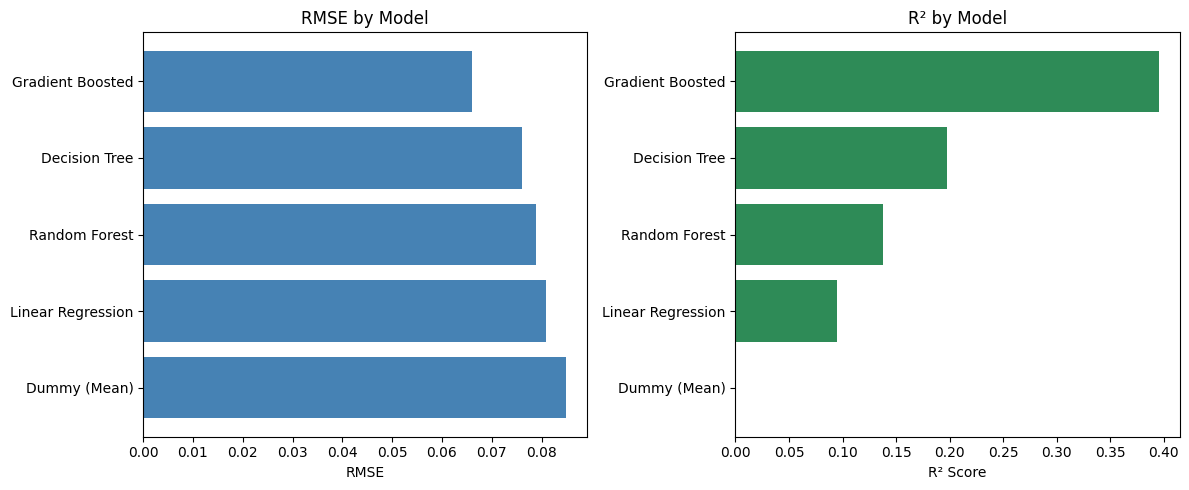

In [90]:
models = df_results["Model"]
rmse_vals = df_results["RMSE"]
r2_vals = df_results["R2"]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].barh(models, rmse_vals, color="steelblue")
ax[0].set_title("RMSE by Model")
ax[0].invert_yaxis()
ax[0].set_xlabel("RMSE")

ax[1].barh(models, r2_vals, color="seagreen")
ax[1].set_title("R² by Model")
ax[1].invert_yaxis()
ax[1].set_xlabel("R² Score")

plt.tight_layout()
plt.show()

From the above graph, we can see Gradient Boosted Tree is the algorithm that performs the best, with the lowest RMSE and best R2 value. The baseline for comparison is mean imputation, which gets beat by all predictors (highest RMSE). We can conclude that using the GBT predictor as imputation method would yield the best results.

## Missing value generation

We can now construct a dataset with the predictions of our missing value predictor

In [94]:
data = spark.read.csv(f"US_Accidents_March23.csv", header=True, inferSchema=True)

In [118]:
predictions = gbt_model.transform(missing_val_merged).select('prediction', 'ID')

In [119]:
predictions.printSchema()

root
 |-- prediction: double (nullable = false)
 |-- ID: string (nullable = true)



In [120]:
new_data = data.join(
    predictions,
    on="ID",
    how="left"
).withColumn(
    "Precipitation(in)",
    when(col("Precipitation(in)").isNull(),
    col("prediction")).otherwise(col("Precipitation(in)"))
).drop("prediction")

In [128]:
print(new_data.count())
print(data.count())

7728394


7728394


In [126]:
new_data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [125]:
print_null_counts(new_data, 23)

+--------------------+----------+
|         Column name|Null Count|
+--------------------+----------+
|             End_Lat|   3402762|
|             End_Lng|   3402762|
|       Wind_Chill(F)|   1999019|
|     Wind_Speed(mph)|    571233|
|   Precipitation(in)|    513662|
|      Visibility(mi)|    177098|
|      Wind_Direction|    175206|
|         Humidity(%)|    174144|
|   Weather_Condition|    173459|
|      Temperature(F)|    163853|
|        Pressure(in)|    140679|
|   Weather_Timestamp|    120228|
|      Sunrise_Sunset|     23246|
|      Civil_Twilight|     23246|
|   Nautical_Twilight|     23246|
|Astronomical_Twil...|     23246|
|        Airport_Code|     22635|
|              Street|     10869|
|            Timezone|      7808|
|             Zipcode|      1915|
|                City|       253|
|         Description|         5|
|             Country|         0|
+--------------------+----------+
only showing top 23 rows



In [129]:
new_data.coalesce(1).write.csv("single_csv", header=True)